### todo
- proactive interference 
    - trial unique stimuli should not yield PI

In [29]:
from datetime import datetime as dt
from glob import glob as glob
import torch as tr
import numpy as np
import itertools

from Nback_tasks import NbackTask_PureEM
from Nback_models import PureEM

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size':22})

%load_ext autoreload
%reload_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load trained models

In [164]:
def load_data(glob_str):
  fpathL = glob(glob_str)
  data_arr = np.ones([len(fpathL)] + list(np.load(fpathL[0]).shape))
  for idx,fpath in enumerate(fpathL):
    data_arr[idx] = np.load(fpath)
  return data_arr

10
10
10


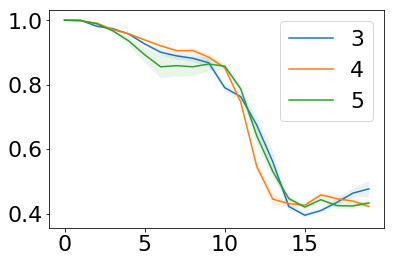

In [171]:
ntokens = 3
nback = 2
seed = '*'

for ntokens in [3,4,5]:
  glob_str = "model_data/pureEM-sweep2/pureEM_25-ntokens_%s-nback_%s-seed_%s-eval_score.npy"%(
                  ntokens,nback,seed)
  acc = load_data(glob_str).mean(1)
  M = acc.mean(0)
  S = acc.std(0)/np.sqrt(len(eval_acc))
  plt.plot(M,label=ntokens)
  plt.fill_between(range(len(M)),M+S,M-S,alpha=.1)
plt.legend()

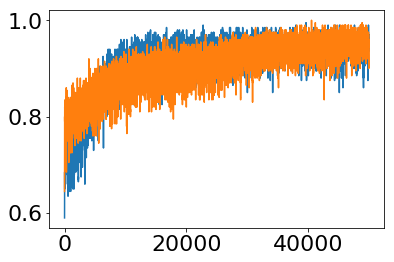

In [207]:
for train_ntokens in [3,10]:
  train_nback = 2
  seed = 0
  fpath = "model_data/pureEM-sweep2/pureEM_25-ntokens_%s-nback_%s-seed_%s-train_score.npy"%(
                train_ntokens,train_nback,seed)
  M = np.load(fpath).mean(1)
  M = mov_avg(M)
  plt.plot(M)

## load model

In [44]:
train_ntokens = 10
train_nback = 1
seed = 1
model_fpath = "model_data/pureEM-sweep2/pureEM_25-ntokens_%s-nback_%s-seed_%s-model.pt"%(
                  train_ntokens,train_nback,seed)

net = PureEM(indim=15,stsize=25,mthresh=.98)
net.load_state_dict(tr.load(model_fpath))

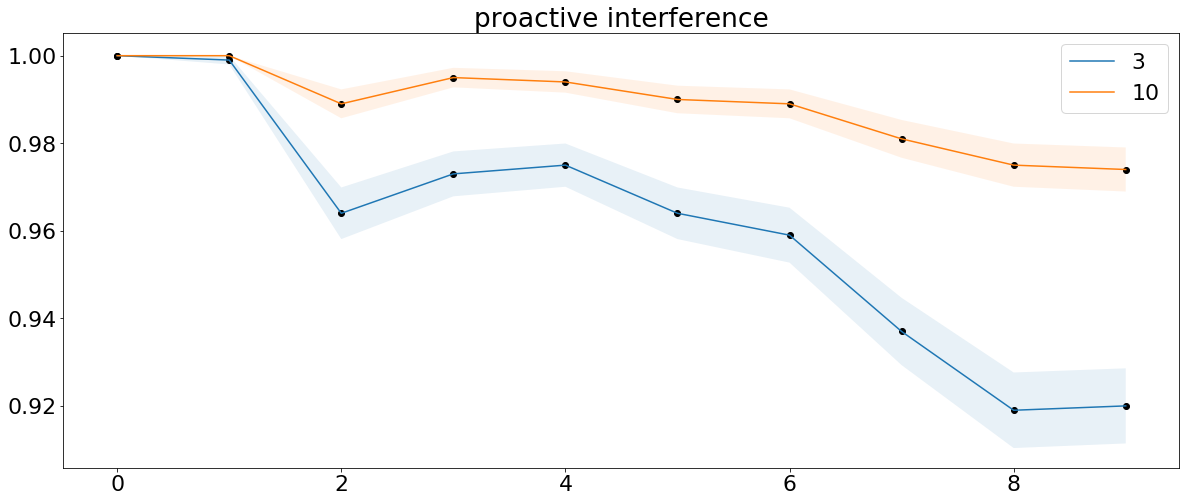

In [50]:
plt.figure(figsize=(20,8))
plt.title('proactive interference')
gen_rand_trials = lambda seqlen: lambda: task.gen_ep_data(seqlen)
nback = 1
ntokens = 3
eval_itr = 1000
for ntokens in [3,10]:
  task = NbackTask_PureEM(nback=nback,ntokens=ntokens,cdrift=.3,cdim=5,sedim=10)
  eval_score = run_model(net,eval_itr,gen_rand_trials(10),training=False,verb=False)
  eval_acc = eval_score.mean(0)
  eval_err = eval_score.std(0)/np.sqrt(eval_itr)
  plt.plot(eval_acc,label=ntokens)
  plt.fill_between(range(len(eval_acc)),eval_acc+eval_err,eval_acc-eval_err,alpha=.1)
  plt.scatter(range(len(eval_acc)),eval_acc,c='black')
plt.legend()


## retrieval

In [46]:
plt.hist?

3
20


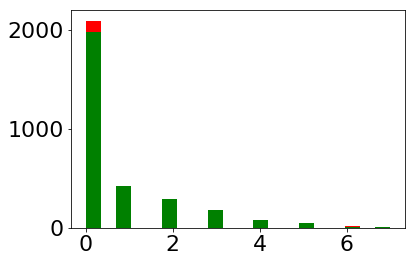

In [51]:
nback = train_nback

cL = ['r','g']
aL = ['left','right']
for idx,ntokens in enumerate([3,20]):
  print(ntokens)
  task = NbackTask_PureEM(nback=nback,ntokens=ntokens,cdrift=.3,cdim=5,sedim=10)
  nitr = 3000
  R = -np.ones(nitr)
  for itr in range(nitr):
    # load EM
    context,stim,yhat=task.gen_ep_data(10)
    y = net.forward(context,stim) 
    # count num retrievals on last trials
    context,stim,yhat=task.gen_ep_data(10)
    query = tr.cat([context[-1],stim[-1]],dim=-1)
    num_retrievals = len(net.retrieve(query))
    R[itr] = num_retrievals
  plt.hist(R,color=cL[idx],bins=20)


# NB
- task used to have a main method that I would always use to generate data
- to allow for flexibility, I'm going to start using it as a modular package that allows generating data in different ways

## main

In [85]:
cdim = 5
sedim = 10
stsize = 25
nback = 1
ntokens = 10

task = NbackTask_PureEM(cdim=cdim,sedim=sedim,nback=nback,ntokens=ntokens)
net = PureEM(indim=cdim+sedim,stsize=stsize)

In [32]:
def run_model(net,neps,gen_data_fn,training=False,verb=False):
  """ gen_data_fn: callable that generates a trial of data (embedded)
  """
  lossop = tr.nn.CrossEntropyLoss()
  optiop = tr.optim.Adam(net.parameters(), lr=0.001)
  # data generating option:
  C,X,Y = gen_data_fn()
  seqlen = len(C)
  # loop
  score = -np.ones([neps,seqlen])    
  for ep in range(neps):
    if ep%(neps/10)==0:
      if verb:print(ep/neps)
    # gen stim
    context,stim,ytarget = gen_data_fn()
    # forward prop
    yhat = net(context,stim)
    score[ep] = tr.argmax(tr.softmax(yhat,-1),-1).squeeze() == ytarget
    if training:
      for tstep in range(seqlen):
        loss = lossop(yhat[tstep],ytarget[:,tstep])
        optiop.zero_grad()
        loss.backward(retain_graph=True)
        optiop.step()
  return score

## train

In [86]:
train_seqlen = 10
train_neps = 100

gen_rand_trials = lambda seqlen: lambda: task.gen_ep_data(seqlen)
train_score = run_model(net,task,train_neps,
                gen_data_fn=gen_rand_trials(train_seqlen),
                training=True,verb=True)

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


In [ ]:
def mov_avg(X,wind=20):
  MA = []
  for t in range(X.shape[0]-wind):
    MA.append(np.mean(X[t:t+wind]))
  return np.array(MA)

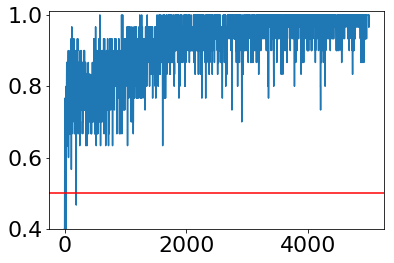

In [78]:
tr_acc = mov_avg(train_score.mean(1),3)
plt.plot(tr_acc)
plt.ylim(0.4,1.01)
plt.axhline(.5,c='r')

## eval on longer sequences

In [90]:
np.save?

In [79]:
eval_score = run_model(net,task,neps=500,
                       gen_data_fn=gen_rand_trials(20),
                       training=False)

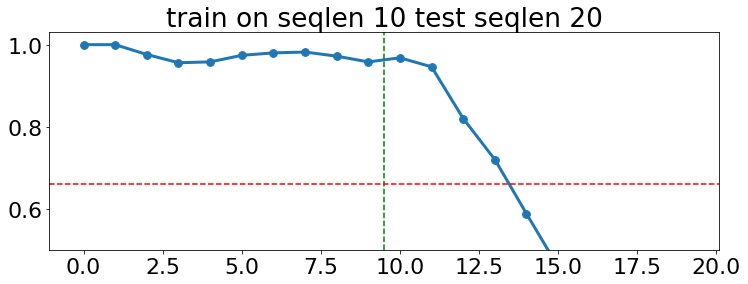

In [80]:
plt.figure(figsize=(12,4))
evacc = eval_score.mean(0)
plt.title('train on seqlen 10 test seqlen 20')
plt.plot(evacc,lw=3)
plt.scatter(range(len(evacc)),evacc,s=60)
plt.axvline(9.5,c='g',ls='--')
plt.ylim(0.5,1.03)
plt.axhline(0.66,c='r',ls='--')
# plt.savefig('figures/temporal_extrapolation')

## intrusion probe

In [11]:
def gen_seq(seqtail,head_len=4,ntokens=3):
  """ 
  given the tail of a sequence
  randomly samples many heads
  """
  seqtail = np.array(seqtail)
  seqhead = np.random.randint(0,ntokens,head_len)
  seq = np.concatenate([seqhead,seqtail])
  return seq


In [13]:
neps = 1500

headlen = 5
seqtail_ctrl = [0,1,2,0]
seqtail_lure = [1,0,2,0]

gen_data_fixtail = lambda seqtail: lambda: task.seq2data(gen_seq(seqtail,head_len=headlen))

score_ctrl = run_model(net,task,neps,gen_data_fn=gen_data_fixtail(seqtail_ctrl))
score_lure = run_model(net,task,neps,gen_data_fn=gen_data_fixtail(seqtail_lure))


nback = 3


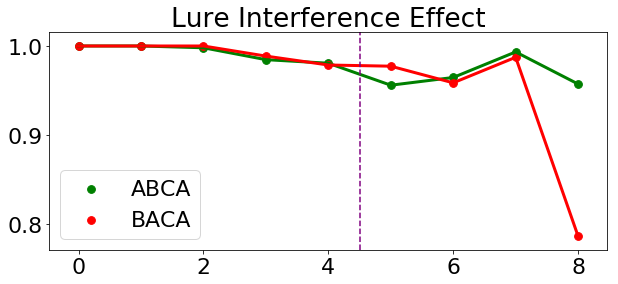

In [40]:
print('nback =',nback)
plt.figure(figsize=(10,4))
cL = ['g','r']
labL = ['ABCA',"BACA"]
ax = plt.gca()
for idx,score in enumerate([score_ctrl,score_lure]):
  acc = score.mean(0)
#   S = score.std(0)/np.sqrt(1500)
#   ax.fill_between(range(len(acc)),acc+S,acc-S,alpha=.3,color=cL[idx])
  ax.plot(acc,c=cL[idx],lw=3)
  ax.scatter(range(len(acc)),acc,c=cL[idx],label=labL[idx],s=60)
ax.axvline(headlen-.5,c='purple',ls='--')
plt.legend()
ax.set_title('Lure Interference Effect')
plt.savefig('figures/lurePIeffect')

# load trained data

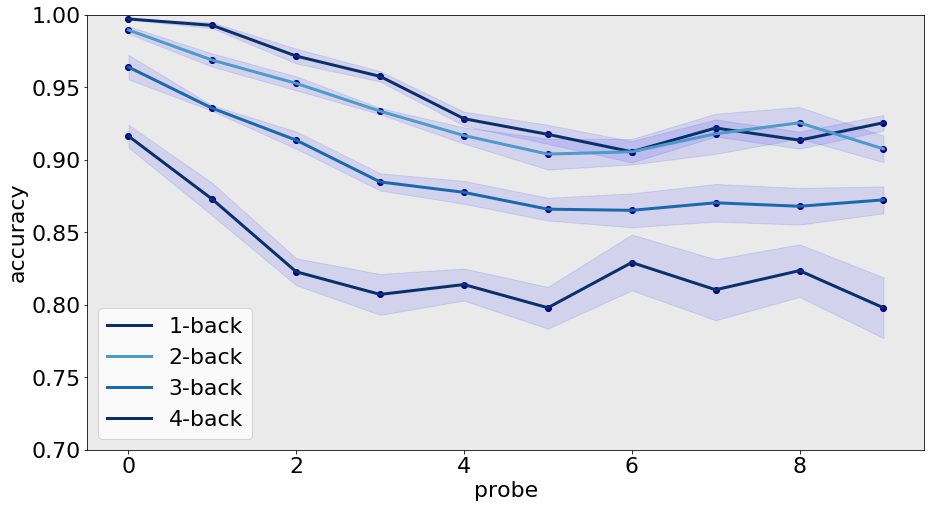

In [11]:
plt.figure(figsize=(15,8))
ax = plt.gca()

nbackL = [1,2,3,4]
driftL = [5]

cL = [plt.get_cmap('Blues')(i) for i in [150,200,300]]
# acc_arr = -np.ones(4,10)
L = []
for drift,nback in itertools.product(driftL,nbackL):
  fpathL = glob('model_data/pureEM-sweep/eval_acc-nback_%i-context_drift_%i-seed_*.npy'%(nback,drift))
  accL = []
  for fpath in fpathL:
    score = np.load(fpath)
    acc = score.mean(0)
    accL.append(acc)
  acc_arr = np.array(accL)
  
  M = acc_arr.mean(0)
  S = acc_arr.std(0)/np.sqrt(len(acc_arr))
  ax.plot(M,label='%i-back'%(nback),lw=3,color=cL[nback-2])
  ax.fill_between(range(len(M)),M-S,M+S,alpha=.1,color='blue')
  ax.scatter(range(len(M)),M,c='darkblue')
  
ax.set_facecolor(plt.get_cmap('Greys')(40))
ax.set_ylabel('accuracy')
ax.set_xlabel('probe')
ax.set_ylim(.7,1)
plt.legend()
# plt.savefig('figures/eval_acc-234back')

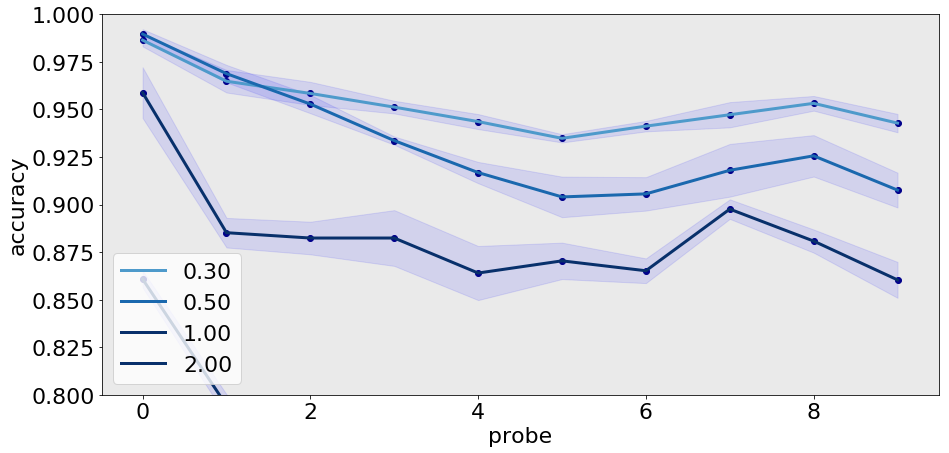

In [10]:
plt.figure(figsize=(15,7))
ax = plt.gca()

nbackL = [2]
driftL = [3,5,10,20]

cL = [plt.get_cmap('Blues')(i) for i in [150,200,300,400]]
# cL = ['r','g','b']
# acc_arr = -np.ones(4,10)
L = []
for idx,(drift,nback) in enumerate(itertools.product(driftL,nbackL)):
  fpathL = glob('model_data/pureEM-sweep/eval_acc-nback_%i-context_drift_%i-seed_*.npy'%(nback,drift))
  accL = []
  for fpath in fpathL:
    score = np.load(fpath)
    acc = score.mean(0)
    accL.append(acc)
  acc_arr = np.array(accL)
  
  M = acc_arr.mean(0)
  S = acc_arr.std(0)/np.sqrt(len(acc_arr))
  ax.plot(M,label='%.2f'%(drift/10),lw=3,color=cL[idx])
  ax.fill_between(range(len(M)),M-S,M+S,alpha=.1,color='blue')
  ax.scatter(range(len(M)),M,c='darkblue')
  
ax.set_facecolor(plt.get_cmap('Greys')(40))
ax.set_ylabel('accuracy')
ax.set_xlabel('probe')
ax.set_ylim(.8,1)
plt.legend()
plt.savefig('figures/eval_acc-bydrift')

## train

In [5]:
## sweeping params
seed = 2
tr.manual_seed(seed)
np.random.seed(seed)

In [8]:
nback=1
ntrials=10+nback
ntokens_og=3
stsize = 30
context_edim = 5
context_drift_std = .5
stim_edim = 10

# ntrials=5
# ntokens_og=3
# stsize = 3
# context_edim = 2
# stim_edim = 2


task = NbackTask_PureEM(ntokens_og,ntrials)
net = PureEM(nback,context_edim+stim_edim,stsize,seed,debug=False)

lossop = tr.nn.CrossEntropyLoss()
optiop = tr.optim.Adam(net.parameters(), lr=0.001)

-- proportion of true trials: M=0.48 S=0.14


In [9]:
nepochs=50000
  
def emb(stim_t_int,context_t_int,stim_emat,context_emat):
  xt_s_emb = stim_emat[stim_t_int].unsqueeze(0)
  xt_c_emb = context_emat[context_t_int].unsqueeze(0)
  xt_emb = tr.cat([xt_s_emb,xt_c_emb],-1) 
  return xt_emb
  
ep_loss = -np.ones([nepochs,ntrials-nback])
A = -np.ones(nepochs)

for ep in range(nepochs):
  if ep%(nepochs/5)==0:
    print(ep/nepochs)
  # embeddings matrices
  context_emat = tr.Tensor(task.generate_context_drift(ntrials,context_edim,context_drift_std))
  stim_emat = tr.randn(ntokens_og,stim_edim)
  # epoch data
  T,X,Y = task.gen_episode_data()
#   print('S=',X)
  X = tr.LongTensor(X)
  Y = tr.LongTensor(Y)
  # initial lstm
  h_t,c_t = tr.zeros(2,1,stsize)
  # initialize memory
  memoryL = []
  for tstep in range(nback):
    xt_emb = emb(X[tstep],tstep,stim_emat,context_emat)
    memoryL.append(xt_emb)
  net.init_memory(memoryL)
  # unroll
  acc = 0
  for tstep in range(nback,ntrials):
    # embed input
    x_t_int = X[tstep]
    xt_emb = emb(X[tstep],tstep,stim_emat,context_emat)
    # fp
    yhat,h_k,c_k = net(xt_emb,h_t,c_t)
    net.encode(xt_emb)
    # bp
    ytarget = Y[tstep].unsqueeze(0)
    loss = lossop(yhat,ytarget)
    ep_loss[ep,tstep-2] = loss.item()
    optiop.zero_grad()
    loss.backward(retain_graph=True)
    optiop.step()
    acc += tr.argmax(tr.softmax(yhat,1),1)==ytarget 
  A[ep] = acc.numpy()/(ntrials-nback)
  


0.0
0.2
0.4
0.6
0.8


In [10]:
def mov_avg(X,wind=20):
  MA = []
  for t in range(X.shape[0]-wind):
    MA.append(np.mean(X[t:t+wind]))
  return np.array(MA)

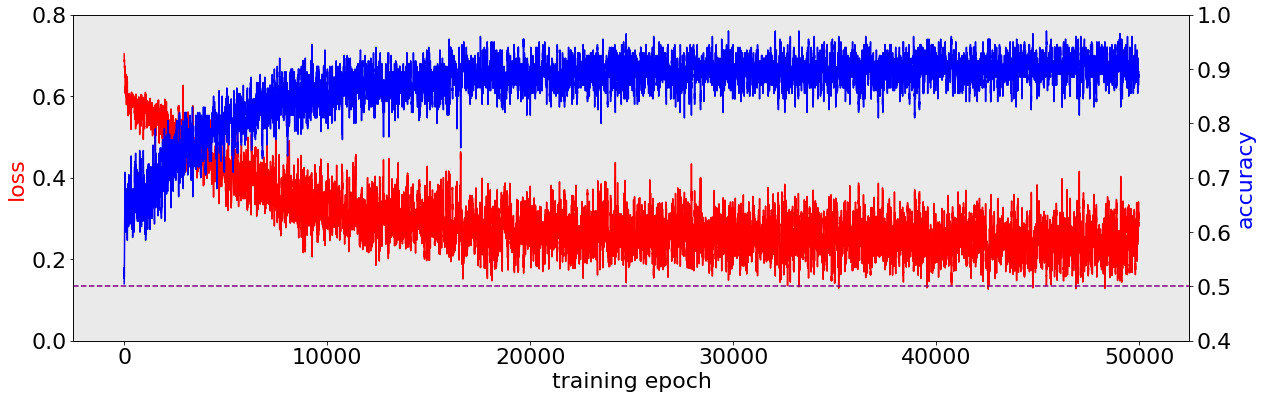

In [12]:
plt.figure(figsize=(20,6))
ax = plt.gca()
ax2 = ax.twinx()

L = ep_loss.mean(1)
ax.plot(mov_avg(L),c='r')
MA = mov_avg(A)
ax2.plot(range(len(MA)),MA,color='blue')

ax.set_ylabel('loss',color='r')
ax.set_xlabel('training epoch',color='k')
ax2.set_ylabel('accuracy',color='blue')
ax2.set_ylim(0.4,1)

ax.set_ylim(0,0.8)
plt.axhline(0.5,c='purple',ls='--')
ax.set_facecolor(plt.get_cmap('Greys')(40))

# plt.savefig('figures/training_loss_acc-nback_%i-drift%i'%(nback,context_drift_std*10))

# eval

In [ ]:
nepochs=500
  
score = -np.ones([nepochs,ntrials-nback])

for ep in range(nepochs):
  if ep%(nepochs/5)==0:
    print(ep/nepochs)
  # embeddings matrices
  context_emat = tr.Tensor(task.generate_context_drift(ntrials,context_edim))
  stim_emat = tr.randn(ntokens_og,stim_edim)
  # epoch data
  T,X,Y = task.gen_episode_data()
#   print('S=',X)
  X = tr.LongTensor(X)
  Y = tr.LongTensor(Y)
  # initial lstm
  h_t,c_t = tr.zeros(2,1,stsize)
  # initialize memory
  memoryL = []
  for tstep in range(nback):
    xt_emb = emb(X[tstep],tstep,stim_emat,context_emat)
    memoryL.append(xt_emb)
  net.init_memory(memoryL)
  # unroll
  for tstep in range(nback,ntrials):
    # embed input
    x_t_int = X[tstep]
    xt_emb = emb(X[tstep],tstep,stim_emat,context_emat)
    # fp
    yhat,h_k,c_k = net(xt_emb,h_t,c_t)
    net.encode(xt_emb)
    # bp
    ytarget = Y[tstep].unsqueeze(0)
    score[ep,tstep-nback] = tr.argmax(tr.softmax(yhat,1),1)==ytarget 

# np.save('model_data/eval_acc-nback_%i-context_drift_%i-seed_%i'%(nback,context_drift_std*10,seed),score)

In [ ]:
plt.figure(figsize=(15,6))

ax = plt.gca()
M = score.mean(0)
S = score.std(0)/np.sqrt(len(score))
# plt.bar(range(len(M)),M,yerr=S)

ax.plot(M,c='b')
ax.scatter(range(len(M)),M,c='darkblue')
ax.fill_between(range(len(M)),M-S,M+S,alpha=.15,color='b')
ax.set_xlabel('eval probe',color='k')
ax.set_ylabel('accuracy',color='k')

ax.set_ylim(0.88,1.01)
ax.set_yticks(np.arange(0.9,1.01,0.05))

for t in np.arange(0.9,1.01,0.025):
  ax.axhline(t,c='k',ls='--',lw=.25)


# plt.savefig('figures/eval_acc-nback_%i-drift%i'%(nback,context_drift_std*10))

## debug


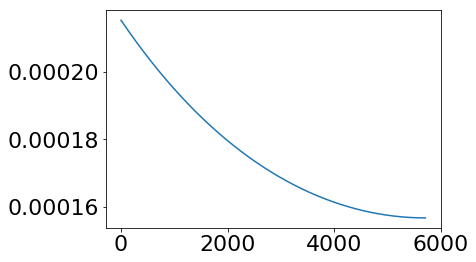

In [82]:
x_t = np.array([np.cos(1),np.sin(1)])

M = np.array([[np.cos(t),np.sin(t)] for t in np.arange(1,np.pi/2,0.0001)])

for g in [1,]:
  kernel = lambda m: np.exp(g*np.linalg.norm(x_t-m)**2)
  K = np.array([kernel(m) for m in M])
  K = K/np.sum(K)
  K = sorted(K)
  K.reverse()
  plt.plot(K)

Text(0.5,1,'x_t - m_t')

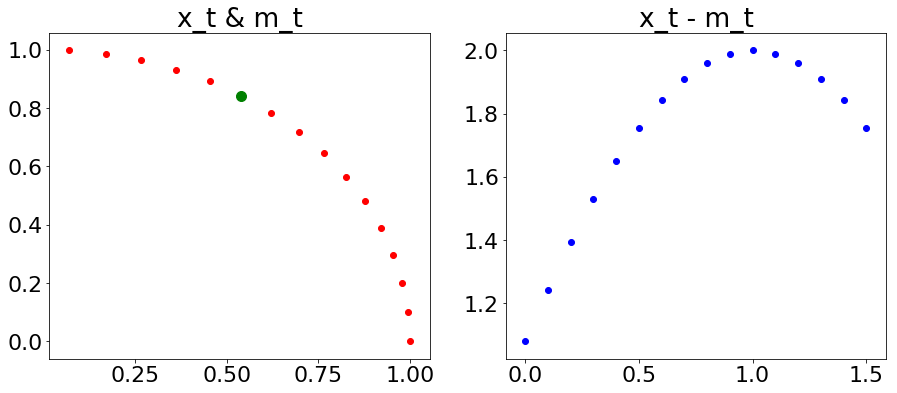

In [3]:
# compute w from k(m_i,x_t)

m1 = np.array([np.cos(1),np.sin(1)])

fig,axarr = plt.subplots(1,2,figsize=(15,6))
for t in np.arange(0,np.pi/2,0.1):
  x_t = np.array([np.cos(t),np.sin(t)])
  axarr[0].scatter(x_t[0],x_t[1],c='r')
  k = 2-np.linalg.norm(x_t-m1)**2
  axarr[1].scatter(t,k,c='b')
  
axarr[0].scatter(m1[0],m1[1],c='g',s=100)
axarr[0].scatter(m2[0],m2[1],c='g',s=100)

axarr[0].set_title('x_t & m_t')
axarr[1].set_title('x_t - m')

In [ ]:
np.linalg.norm()